# Preparing the environment


## Libraries

In [1]:
#%pip install --upgrade pip
#%pip install pandas
#%pip install scipy 
#%pip install scikit-learn 
#%pip install tqdm 
#%pip install plotly 
#%pip install matplotlib
#%pip install nbformat
#%pip install fastparquet
#%pip install pyarrow

In [2]:
# requirements
import pandas as pd
import numpy as np
from scipy.stats import chi2, poisson, chisquare
from scipy.stats import entropy  # for KL (use small-smoothing)
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
from tqdm import tqdm
import math, json
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.graph_objects as go

# Dataset 1 - The APA DDoS Dataset

The APA DDoS Dataset, available at [Kaggle](https://www.kaggle.com/datasets/yashwanthkumbam/apaddos-dataset), is a HTTP request report containing IP source address, destinatination ip addres, request time frame and the attack label.



## Preparing the dataset
To make it useful for this project test, it was necessary to convert the columns name to the equivalent words used by the modules. The project assumes that the request information includes a HTTP method and an API endpoint, that is why the column ip.dst was converted to URI column.

In [2]:
import pandas as pd
ddos_data=pd.read_csv('./datasets/APA-DDoS-Dataset.csv')
ddos_data = ddos_data[['ip.src', 'ip.dst', 'frame.time', 'Label']] # original names
ddos_data.columns = ['address', 'uri', 'time_local', 'label'] # converted names

The time_local columns had to be formatted to discard miliseconds and location.

In [3]:
import re

ddos_data['time_local'] = ddos_data['time_local'].astype(str)
ddos_data['time_local'] = ddos_data['time_local'].apply(lambda x: re.findall('\d{2}-\w{3} \d{4} \d{2}:\d{2}:\d{2}', x)[0])
ddos_data['time_local'] = pd.to_datetime(ddos_data['time_local'])

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\loren\AppData\Local\Temp\ipykernel_4192\1667082320.py:4: SyntaxWarning: invalid escape sequence '\d'
  ddos_data['time_local'] = ddos_data['time_local'].apply(lambda x: re.findall('\d{2}-\w{3} \d{4} \d{2}:\d{2}:\d{2}', x)[0])


Below it is shown the number of reports benign traffic for each 5min-window. As can be seen, it was only possible to acquire 7 windows, and their reports are imbalanced.


In [4]:
ddos_data_benign = ddos_data.loc[ddos_data['label'] == 'Benign']
ddos_data_benign.groupby(pd.Grouper(key='time_local', freq='5min')).count()

,address,uri,label
time_local,,,
2020-06-16 20:15:00,6122,6122,6122
2020-06-16 20:20:00,19140,19140,19140
2020-06-16 20:25:00,12538,12538,12538
2020-06-16 20:30:00,0,0,0
2020-06-16 20:35:00,0,0,0
2020-06-16 20:40:00,0,0,0
2020-06-16 20:45:00,0,0,0
2020-06-16 20:50:00,0,0,0
2020-06-16 20:55:00,0,0,0


In this experiment, a 5 minute window was fixed. Below it is shown the number of attack traffic reports for each 5min-window. It was also only possible to acquire 7 windows, and their reports are imbalanced.

In [5]:
ddos_data_attack = ddos_data.loc[~(ddos_data['label'] == 'Benign')].sort_values(by='time_local', ascending=True)
ddos_data_attack.groupby(pd.Grouper(key='time_local', freq='1min')).count()

,address,uri,label
time_local,,,
2020-06-16 20:18:00,5400,5400,5400
2020-06-16 20:19:00,5400,5400,5400
2020-06-16 20:20:00,0,0,0
2020-06-16 20:21:00,5400,5400,5400
2020-06-16 20:22:00,5400,5400,5400
...,...,...,...
2020-06-16 22:04:00,0,0,0
2020-06-16 22:05:00,5400,5400,5400
2020-06-16 22:06:00,0,0,0


In [6]:
groups = ddos_data.loc[ddos_data['time_local'] < datetime.strptime('2020-06-16 22:10:00', '%Y-%m-%d %H:%M:%S')].groupby(pd.Grouper(key='time_local', freq='5min')).count()
groups.shape

(23, 3)

In [7]:
from datetime import timedelta

groups = ddos_data.loc[ddos_data['time_local'] < datetime.strptime('2020-06-16 22:10:00', '%Y-%m-%d %H:%M:%S')].groupby(pd.Grouper(key='time_local', freq='5min')).count()

for index, group in groups.iterrows():
  end_interval = index + timedelta(minutes=5)
  dataset = ddos_data.loc[(ddos_data['time_local'] >= index) & (ddos_data['time_local'] < end_interval)]
  if(dataset.size > 0):
    display(dataset)
  #print(f"time: {index} | end: {end_interval}")

,address,uri,time_local,label
0,192.168.1.1,192.168.23.2,2020-06-16 20:18:15,DDoS-PSH-ACK
1,192.168.1.1,192.168.23.2,2020-06-16 20:18:15,DDoS-PSH-ACK
2,192.168.1.1,192.168.23.2,2020-06-16 20:18:15,DDoS-PSH-ACK
3,192.168.1.1,192.168.23.2,2020-06-16 20:18:15,DDoS-PSH-ACK
4,192.168.1.1,192.168.23.2,2020-06-16 20:18:15,DDoS-PSH-ACK
...,...,...,...,...
43917,192.168.5.1,192.168.23.2,2020-06-16 20:19:59,Benign
43918,192.168.5.1,192.168.23.2,2020-06-16 20:19:59,Benign
43919,192.168.5.1,192.168.23.2,2020-06-16 20:19:59,Benign
43920,192.168.5.1,192.168.23.2,2020-06-16 20:19:59,Benign


,address,uri,time_local,label
10800,192.168.7.1,192.168.23.2,2020-06-16 20:21:14,DDoS-PSH-ACK
10801,192.168.7.1,192.168.23.2,2020-06-16 20:21:14,DDoS-PSH-ACK
10802,192.168.7.1,192.168.23.2,2020-06-16 20:21:14,DDoS-PSH-ACK
10803,192.168.7.1,192.168.23.2,2020-06-16 20:21:14,DDoS-PSH-ACK
10804,192.168.7.1,192.168.23.2,2020-06-16 20:21:14,DDoS-PSH-ACK
...,...,...,...,...
63057,192.168.13.1,192.168.23.2,2020-06-16 20:24:59,Benign
63058,192.168.13.1,192.168.23.2,2020-06-16 20:24:59,Benign
63059,192.168.13.1,192.168.23.2,2020-06-16 20:24:59,Benign
63060,192.168.13.1,192.168.23.2,2020-06-16 20:24:59,Benign


,address,uri,time_local,label
27000,192.168.11.1,192.168.23.2,2020-06-16 20:25:27,DDoS-PSH-ACK
27001,192.168.11.1,192.168.23.2,2020-06-16 20:25:27,DDoS-PSH-ACK
27002,192.168.11.1,192.168.23.2,2020-06-16 20:25:27,DDoS-PSH-ACK
27003,192.168.11.1,192.168.23.2,2020-06-16 20:25:27,DDoS-PSH-ACK
27004,192.168.11.1,192.168.23.2,2020-06-16 20:25:27,DDoS-PSH-ACK
...,...,...,...,...
75595,192.168.19.1,192.168.23.2,2020-06-16 20:28:21,Benign
75596,192.168.19.1,192.168.23.2,2020-06-16 20:28:21,Benign
75597,192.168.19.1,192.168.23.2,2020-06-16 20:28:21,Benign
75598,192.168.19.1,192.168.23.2,2020-06-16 20:28:21,Benign


,address,uri,time_local,label
75600,192.168.1.1,192.168.23.2,2020-06-16 21:57:57,DDoS-ACK
75601,192.168.1.1,192.168.23.2,2020-06-16 21:57:57,DDoS-ACK
75602,192.168.1.1,192.168.23.2,2020-06-16 21:57:57,DDoS-ACK
75603,192.168.1.1,192.168.23.2,2020-06-16 21:57:57,DDoS-ACK
75604,192.168.1.1,192.168.23.2,2020-06-16 21:57:57,DDoS-ACK
...,...,...,...,...
120224,192.168.5.1,192.168.23.2,2020-06-16 21:59:59,Benign
120225,192.168.5.1,192.168.23.2,2020-06-16 21:59:59,Benign
120226,192.168.5.1,192.168.23.2,2020-06-16 21:59:59,Benign
120227,192.168.5.1,192.168.23.2,2020-06-16 21:59:59,Benign


,address,uri,time_local,label
86400,192.168.7.1,192.168.23.2,2020-06-16 22:01:09,DDoS-ACK
86401,192.168.7.1,192.168.23.2,2020-06-16 22:01:09,DDoS-ACK
86402,192.168.7.1,192.168.23.2,2020-06-16 22:01:09,DDoS-ACK
86403,192.168.7.1,192.168.23.2,2020-06-16 22:01:09,DDoS-ACK
86404,192.168.7.1,192.168.23.2,2020-06-16 22:01:09,DDoS-ACK
...,...,...,...,...
134650,192.168.16.1,192.168.23.2,2020-06-16 22:04:59,Benign
134651,192.168.16.1,192.168.23.2,2020-06-16 22:04:59,Benign
134652,192.168.16.1,192.168.23.2,2020-06-16 22:04:59,Benign
134653,192.168.16.1,192.168.23.2,2020-06-16 22:04:59,Benign


,address,uri,time_local,label
97200,192.168.14.1,192.168.23.2,2020-06-16 22:05:19,DDoS-ACK
97201,192.168.14.1,192.168.23.2,2020-06-16 22:05:19,DDoS-ACK
97202,192.168.14.1,192.168.23.2,2020-06-16 22:05:19,DDoS-ACK
97203,192.168.14.1,192.168.23.2,2020-06-16 22:05:19,DDoS-ACK
97204,192.168.14.1,192.168.23.2,2020-06-16 22:05:19,DDoS-ACK
...,...,...,...,...
148521,192.168.19.1,192.168.23.2,2020-06-16 22:09:57,Benign
148522,192.168.19.1,192.168.23.2,2020-06-16 22:09:57,Benign
148523,192.168.19.1,192.168.23.2,2020-06-16 22:09:57,Benign
148524,192.168.19.1,192.168.23.2,2020-06-16 22:09:57,Benign


# Dataset 2 - CICDDoS2019

The CICDDoS2019, available at [University of New Brunswick website](https://www.unb.ca/cic/datasets/ddos-2019.html), contains different kinds of DDoS attacks and realistic traffic profiles. It is a HTTP request report containing IP source address, destinatination ip addres, request time frame and the attack label.


## Preparing the dataset

Analysing csv columns to convert it in HTTP equivalent data.

In [114]:
file_ext='csv'
cic_03_11_path=f"./datasets/UDP-training.{file_ext}"
cic_01_12_path=f"./datasets/UDP-testing.{file_ext}"

In [115]:
cic_03_11_df=pd.read_csv(cic_03_11_path)
cic_03_11_df.columns

C:\Users\Patricia Mamed\AppData\Local\Temp\ipykernel_30096\2500374420.py:1: DtypeWarning:

Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.



Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Len

In [116]:
cic_01_12_df=pd.read_csv(cic_01_12_path)
cic_01_12_df.columns

C:\Users\Patricia Mamed\AppData\Local\Temp\ipykernel_30096\2554759298.py:1: DtypeWarning:

Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.



Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Len

In [117]:
def prepare_columns(df):
	"""Converting columns to represent HTTP endpoints"""
	df = df[[' Source IP', ' Destination IP', ' Destination Port', ' Timestamp', ' Label']].copy()
	
	df[' Destination IP'] = df[' Destination IP'].astype(str)
	df[' Destination Port'] = df[' Destination Port'].astype(str) 
	df['uri'] = df[' Destination IP'] + ':' + df[' Destination Port']
	df = df[[ ' Source IP', 'uri', ' Timestamp', ' Label']] # original names
	df.columns = ['address', 'uri', 'time_local', 'label'] # converted names

	# parse timestamp
	df['time_local'] = pd.to_datetime(df['time_local'], errors='coerce')
	df = df.dropna(subset=['time_local'])

	# create normalized columns
	df['time_local'] = df['time_local'].dt.floor('s')
	df['uri'] = df['uri'].astype(str)
	df['address'] = df['address'].astype(str)
	df['label'] = df['label'].astype(str)

	return df

In [118]:
df_1 = prepare_columns(cic_03_11_df)
df_1.head()

,address,uri,time_local,label
0,172.16.0.5,192.168.50.4:3281,2018-11-03 10:56:24,UDP
1,172.16.0.5,192.168.50.4:51895,2018-11-03 10:53:53,UDP
2,172.16.0.5,192.168.50.4:2669,2018-11-03 10:54:40,UDP
3,172.16.0.5,192.168.50.4:2841,2018-11-03 10:59:17,UDP
4,172.16.0.5,192.168.50.4:34136,2018-11-03 10:57:43,UDP


In [119]:
df_2 = prepare_columns(cic_01_12_df)
df_2.head()

,address,uri,time_local,label
0,172.16.0.5,192.168.50.1:33616,2018-12-01 13:03:46,DrDoS_UDP
1,172.16.0.5,192.168.50.1:8501,2018-12-01 12:56:24,DrDoS_UDP
2,172.16.0.5,192.168.50.1:54577,2018-12-01 13:02:23,DrDoS_UDP
3,172.16.0.5,192.168.50.1:56519,2018-12-01 13:03:59,DrDoS_UDP
4,172.16.0.5,192.168.50.1:7150,2018-12-01 13:03:57,DrDoS_UDP


In [120]:
df_1.value_counts('label')

label
UDP       28024
BENIGN     3134
MSSQL       182
Name: count, dtype: int64

In [121]:
df_2.value_counts('label')

label
DrDoS_UDP    19413
BENIGN        2157
Name: count, dtype: int64

In [122]:
def eda_label(df):
	time_col = 'time_local'
	label_col = 'label'

	df[time_col] = pd.to_datetime(df[time_col])

	# Resample (e.g. per minute, per second, etc.)
	# Choose the frequency depending on your dataset ('1T' = 1 minute, '1S' = 1 second, etc.)
	counts = df.groupby([label_col, pd.Grouper(key=time_col, freq='min')]).size().reset_index(name='count')

	# Plot evolution over time
	fig = px.line(counts, x=time_col, y='count', color=label_col,
				title='Event frequency over time',
				labels={time_col: 'Time', 'count': 'Count'})
	fig.show()

In [123]:
def eda_label(df):
	time_col = 'time_local'
	label_col = 'label'

	df[time_col] = pd.to_datetime(df[time_col])

	# Resample (e.g. per minute, per second, etc.)
	# Choose the frequency depending on your dataset ('1T' = 1 minute, '1S' = 1 second, etc.)
	counts = df.groupby([label_col, pd.Grouper(key=time_col, freq='min')]).size().reset_index(name='count')

		# Plot evolution over time
	fig = px.line(counts, x=time_col, y='count', color=label_col,
				title='Event frequency over time',
				labels={time_col: 'Time', 'count': 'Count'})

	fig.show()



In [124]:
df_benign_1 = df_1[df_1['label'] == 'BENIGN'].copy()

eda_label(df_1)

In [125]:
df_benign_2 = df_2[df_2['label'] == 'BENIGN'].copy()

eda_label(df_2)

## Training phase: identifying typical traffic behavior

In [126]:
### TRAINING MODULE: detects typical traffic flow

def compute_lambda_by_api_endpoint(df, label_benign='BENIGN', window_seconds=60):
	train_df = df[df['label'].astype(str).str.upper() == label_benign.upper()]

	lambdas = {}

	# time range for entire trace (use global range to create aligned second index)
	tmin = df['time_local'].min()
	tmax = df['time_local'].max()

	# for each uri compute per-second counts and windowed mean
	groups = train_df.groupby(['uri'])

	for uri, g in groups:
		# for each timestamp calculates the total of requests
		counts = g.groupby('time_local').size() 

		# reindex full second range for stability
		# to avoid missing seconds
		all_seconds = pd.date_range(tmin, tmax, freq='s')
		counts = counts.reindex(all_seconds, fill_value=0)
		arr = counts.values
		
		# filtra os segundos do 
		if len(arr) < window_seconds:
			lam = arr.mean()
		else:
			# calculates how many windows are in the interval
			# // return floor round, so the result can be lower
			# e.g. 7 secs // 3 secs -> 2 windows (only considers 6 seconds)
			n_win = len(arr) // window_seconds

			# filters interval to the exact windows size
			arr = arr[:n_win*window_seconds]
			
			# fragments the interval in the number of windows
			arr = arr.reshape(n_win, window_seconds)

			# calculates each window mean
			window_means = arr.sum(axis=1) / window_seconds

			# computes the mean of the means as lambda
			lam = max(window_means.mean(), 0.0)
		lambdas[uri] = lam
	return lambdas

In [127]:
endpoints_lambdas = compute_lambda_by_api_endpoint(df_1, window_seconds=60)
print('Computed lambda for {} API-endpoint pairs'.format(len(endpoints_lambdas)))

for uri, lam in endpoints_lambdas.items():
    print(f"endpoint: {uri}  lambda: {lam}")

Computed lambda for 630 API-endpoint pairs
endpoint: ('104.19.195.151:443',)  lambda: 0.0
endpoint: ('104.20.11.130:443',)  lambda: 0.002777777777777778
endpoint: ('104.20.12.130:443',)  lambda: 0.012037037037037035
endpoint: ('104.20.12.130:80',)  lambda: 0.004629629629629629
endpoint: ('104.36.115.113:443',)  lambda: 0.0287037037037037
endpoint: ('104.88.15.186:443',)  lambda: 0.003703703703703704
endpoint: ('112.121.107.16:443',)  lambda: 0.002777777777777778
endpoint: ('112.121.107.20:443',)  lambda: 0.01759259259259259
endpoint: ('112.121.107.29:3001',)  lambda: 0.002777777777777778
endpoint: ('112.121.107.46:443',)  lambda: 0.012962962962962963
endpoint: ('112.121.107.47:443',)  lambda: 0.008333333333333335
endpoint: ('118.163.124.247:443',)  lambda: 0.016666666666666666
endpoint: ('125.227.128.31:443',)  lambda: 0.014814814814814815
endpoint: ('13.68.93.109:443',)  lambda: 0.001851851851851852
endpoint: ('139.162.11.86:443',)  lambda: 0.003703703703703704
endpoint: ('139.162.22.

## Monitoring phase: observes traffic for atypical behavior

In [128]:
### MONITORING MODULE: Observes the traffic and compare with the registered lambdas
def kl_divergence(p, q):
	''' Calculates KL divergence between p and q'''
	SIG_EPS = 1e-10 # avoids division by zero
	p = np.asarray(p, dtype=float) + SIG_EPS
	q = np.asarray(q, dtype=float) + SIG_EPS
	return entropy(p, q)

def gaussian_membership(u, mu=0.0, sigma=1.0):
    return math.exp(-((u-mu)**2) / (2*(sigma**2)))

def calculate_D(obs_counts, expected, alpha, pmf_y, dX):
	# checks for anomaly
	try:
		_, pval = chisquare(f_obs=obs_counts, f_exp=expected)
	except Exception:
		_, pval = np.nan, 1.0
	if pval < alpha:
		D = kl_divergence(pmf_y, dX)
	else:
		D = 0.0
	return D

def extract_traffic_changes(obs_counts, expected, alpha, pmf_y, dX, current_window, lambda_ep, seconds_in_window):
	D = calculate_D(obs_counts, expected, alpha, pmf_y, dX)
	Xbar = current_window.mean()
	Delta = (Xbar - lambda_ep) / max(lambda_ep, 1)
	Z = (Xbar - lambda_ep) / math.sqrt(max(lambda_ep, 1) / seconds_in_window)
	return D, Delta, Z

def fuzzification(current_window, D, Delta, Z):
	sigma_u = max(1.0, np.std(current_window))  # adaptive width
	fD = gaussian_membership(D, mu=0.0, sigma=sigma_u)
	fDelta = gaussian_membership(Delta, mu=0.0, sigma=sigma_u)
	fZ = gaussian_membership(Z, mu=0.0, sigma=sigma_u)
	return fD, fDelta, fZ

def anomaly_score(fD, fDelta, fZ, wDelta, wD, wZ):
	fDprime = 1 - fD
	fDelprime = 1 - fDelta
	fZprime = 1 - fZ
	eta = fDelprime + fDprime + fZprime
	return eta

def sample_expected_traffic(max_count, current_window, lambda_ep):
	# samples a poisson pmf for the estimated lambda
	bins = np.arange(0, max_count+1)
	dY = poisson.pmf(bins, mu=lambda_ep)
	if dY.sum() == 0:
		# if pmf invalid, uses a uniform
		dY = np.ones_like(dY) / len(dY)
	else:
		dY = dY / dY.sum()
	expected_traffic = dY * current_window.size
	return expected_traffic, dY

def get_observed_traffic(max_count, current_window):
	obs_traffic, _ = np.histogram(current_window, bins=np.arange(0,max_count+2))
	if obs_traffic.sum() == 0:
		dX = np.zeros_like(obs_traffic, dtype=float)
	else:
		dX = obs_traffic / obs_traffic.sum()
	return obs_traffic, dX


def analyze_window(current_window, lambda_endpoint, seconds_in_window=60, alpha=0.05, beta=1.0, zeta=0.5, wD=0.5, wDelta=0.3, wZ=0.2):
	''''''
	max_count = max(int(current_window.max()), int(lambda_endpoint*2)+5)
	
	obs_traffic, dX = get_observed_traffic(max_count, current_window)
	exp_traffic, dY = sample_expected_traffic(max_count, current_window, lambda_endpoint)

	D, Delta, Z = extract_traffic_changes(obs_traffic, exp_traffic, alpha, dY, dX, current_window, lambda_endpoint, seconds_in_window)
	fD, fDelta, fZ = fuzzification(current_window, D, Delta, Z)
	eta = anomaly_score(fD, fDelta, fZ, wDelta, wD, wZ)	

	#C2 = (1 - zeta) * math.tanh(beta - D) + zeta * (1 - eta)
	#C2 = math.tanh(1.764 * (-eta + 1.5))
	C2 = beta - eta/3
	C22 = math.tanh(beta - D)

	return {'D': D, 'Delta': Delta, 'Z': Z, 'eta': eta, 'C2': C2, 'C22': C22, 'fD': fD, 'fDelta': fDelta, 'fZ': fZ}

In [129]:
def scaled_sigmoid(x, alpha=3.063, beta=0.5):
    return 1 / (1 + np.exp(-alpha * (x - beta)))

def update_Ra(old_Ra, C2):
	new_Ra = scaled_sigmoid(old_Ra + C2)
	return new_Ra	

# Main sweep function. It builds windowed results per uri.
def run_detection(df, endpoints_lambdas, seconds_in_window=60, stride_seconds=None,
                  alpha=0.05, beta=0.5, zeta=0.5, wD=0.2, wDelta=0.1, wZ=0.7,
                  init_Ra=1.0, init_Rc=1.0, rc_clients=None):
	# window sliding
	if stride_seconds is None:
		stride_seconds = seconds_in_window

	# creates per uri second-aligned series (global time index)
	tmin = df['time_local'].min()
	tmax = df['time_local'].max()
	full_index = pd.date_range(tmin, tmax, freq='s')

	results = []
	Ra = {}
	Ra_2 = {}
	Rc = {} if rc_clients is None else rc_clients.copy() # uses clients reputations history if provided
	
	# creates a mapping from per-second windows to whether any attack occurred in that window (groundtruth)
	df['is_attack'] = ~df['label'].astype(str).str.upper().eq('BENIGN')
	per_sec_attacks = df.groupby('time_local')['is_attack'].any().reindex(full_index, fill_value=False)
	
	# groups by api+endpoint to get requests per second
	grouped = df.groupby('uri')

	# for every endpoint, shows progress
	for uri, g in tqdm(grouped, desc='APIs'):
		# builds per-second request series for this endpoint
		requests_per_sec = g.groupby('time_local').size().reindex(full_index, fill_value=0).values
		lam = endpoints_lambdas.get(uri, requests_per_sec.mean())
		Ra[uri] = init_Ra
		Ra_2[uri] = init_Ra
		secs = len(requests_per_sec)

		# iterates all windows start
		for start in range(0, secs - seconds_in_window + 1, stride_seconds):
			current_window = requests_per_sec[start:start+seconds_in_window]
			out = analyze_window(current_window, lam, seconds_in_window, alpha, beta, zeta, wD, wDelta, wZ)
			Ra[uri] = update_Ra(Ra[uri], out['C2'])
			Ra_2[uri] = update_Ra(Ra_2[uri], out['C22'])
			
			# map window start time to actual timestamp for groundtruth labeling
			win_start_ts = full_index[start]
			win_end_ts = full_index[start+seconds_in_window-1]
			# groundtruth: if any flow to this API-endpoint in window is attack -> attack window for this pair
			mask = (g['time_local'] >= win_start_ts) & (g['time_local'] <= win_end_ts)
			label_attack = g.loc[mask, 'is_attack'].any()
			results.append({
				'endpoint': uri, 'win_start': win_start_ts,
				'win_end': win_end_ts, 'lambda': lam, 'C2': out['C2'], 'D': out['D'],
				'Delta': out['Delta'], 'Z': out['Z'], 'eta': out['eta'],
				'Ra': Ra[uri], 'label_attack': bool(label_attack),
				'Ra_2': Ra_2[uri], 'fDP': 1-out['fD'], 'fDeltaP': 1-out['fDelta'], 'fZP': 1-out['fZ']
			})
	res_df = pd.DataFrame(results)
	return res_df

In [130]:
#res_df = run_detection(df_1, endpoints_lambdas, seconds_in_window=60)
#print('Detection sweep completed. Windows:', len(res_df))
#display(res_df.head())

# Evaluation

In [133]:
def evaluate_results(res_df, ra_threshold=0.5, plot_examples=5):
	if res_df is None or len(res_df)==0:
		print('No results to evaluate.')
		return
	# make binary predictions using Ra threshold (lower Ra -> more anomalous)
	y_true = res_df['label_attack'].astype(int).values
	y_score = 1 - res_df['C2'].astype(float).values
	y_pred = (y_score > 1).astype(int)  # equivalent to C2 < 0
	precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
	roc = roc_auc_score(y_true, y_score) if len(np.unique(y_true))>1 else float('nan')
	print(f'Precision={precision:.4f}  Recall={recall:.4f}  F1={f1:.4f}  ROC_AUC={roc:.4f}')
	# simple confusion table
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
	print('TP',tp,'FP',fp,'FN',fn,'TN',tn)

	# plot Ra timeseries for some example api-endpoints
	unique_pairs = res_df['endpoint'].drop_duplicates().sample(min(plot_examples, len(res_df)))
	for endpoint in unique_pairs:
		time_col = 'win_end'
		sub = res_df[res_df['endpoint'] == endpoint].sort_values(time_col).copy()
		sub['label_attack'] = sub['label_attack'].map({True: 'Attack', False: 'Benign'})

		fig = go.Figure()

		# --- Ra dots (colored by attack label) ---
		color_map = {'Benign': 'green', 'Attack': 'red'}
		fig.add_trace(go.Scatter(
			x=sub[time_col],
			y=sub['Ra'],
			mode='markers',
			marker=dict(
				color=sub['label_attack'].map(color_map),
				size=7,
				line=dict(width=0.5, color='black')
			),
			name='Ra (colored by Attack/Benign)',
			hovertemplate='Time: %{x}<br>Ra: %{y:.3f}<br>Status: %{marker.color}<extra></extra>')
		)

		# --- Other metrics (D, Z, Delta) as simple lines ---
		metric_colors = {'D': '#1f77b4', 
				   'Z': '#ff7f0e', 
				   'Delta': '#2ca02c', 
				   'eta': "#fde861", 
				   'Ra_2': "#fd61bc", 
				   'C2': "#ff0000", 
				   'fDP': "#ff00ff", 
				   'fDeltaP': "#00c3ff", 
				   'fZP': "#bbff00"}  # distinct line colors

		for metric, color in metric_colors.items():
			fig.add_trace(go.Scatter(
				x=sub[time_col],
				y=sub[metric],
				mode='lines',
				line=dict(color=color, width=2),
				name=metric
			))

		# --- Layout ---
		fig.update_layout(
			title=f'Metrics evolution for the {endpoint}',
			xaxis_title='Time',
			yaxis_title='Metric value',
			template='plotly_white',
			legend_title_text='Metric',
			margin=dict(l=50, r=30, t=60, b=40)
		)

		return fig

In [ ]:
#evaluate_results(res_df, ra_threshold=0.5, plot_examples=3)

Precision=0.0000  Recall=0.0000  F1=0.0000  ROC_AUC=0.9978
TP 0 FP 18 FN 24524 TN 389458


In [134]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import os

t_minutes = [1, 5, 10, 30]
beta = [0.2, 0.4, 0.6, 0.8]

os.makedirs("results", exist_ok=True)

def worker(params):
    t, b = params
    try:
        res_df = run_detection(df_1, endpoints_lambdas, seconds_in_window=60*t, beta=b)
        fig = evaluate_results(res_df, ra_threshold=b, plot_examples=3)
        path = f"results/plot_t{t}_b{b}.html"
        fig.write_html(path)
        return (t, b, path)
    except Exception as e:
        import traceback
        tb = traceback.format_exc()
        return (t, b, f"ERRO: {e}\n{tb}")


param_combos = [(t, b) for t in t_minutes for b in beta]

if __name__ == "__main__":
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(worker, p) for p in param_combos]
        for f in tqdm(as_completed(futures), total=len(futures), desc="Executando"):
            try:
                t, b, path = f.result()
                print(f"✅ Terminou t={t}, b={b} → salvo em {path}")
            except Exception as e:
                print(f"❌ Erro em uma tarefa: {e}")


Executando: 100%|██████████| 16/16 [00:00<00:00, 82.69it/s]

❌ Erro em uma tarefa: A process in the process pool was terminated abruptly while the future was running or pending.
❌ Erro em uma tarefa: A process in the process pool was terminated abruptly while the future was running or pending.
❌ Erro em uma tarefa: A process in the process pool was terminated abruptly while the future was running or pending.
❌ Erro em uma tarefa: A process in the process pool was terminated abruptly while the future was running or pending.
❌ Erro em uma tarefa: A process in the process pool was terminated abruptly while the future was running or pending.
❌ Erro em uma tarefa: A process in the process pool was terminated abruptly while the future was running or pending.
❌ Erro em uma tarefa: A process in the process pool was terminated abruptly while the future was running or pending.
❌ Erro em uma tarefa: A process in the process pool was terminated abruptly while the future was running or pending.
❌ Erro em uma tarefa: A process in the process pool was terminat

In [132]:
# Run evaluation if res_df exists
t_minutes = [1*60, 5*60, 10*60]
beta = [0.2, 0.4, 0.6]

param_combos = [(t, b) for t in t_minutes for b in beta]
for t,b in param_combos:
    res_df = run_detection(df_1, endpoints_lambdas, seconds_in_window=t, beta=b)
    evaluate_results(res_df, ra_threshold=b, plot_examples=3)
#print('Detection sweep completed. Windows:', len(res_df))
#display(res_df.head())

APIs: 100%|██████████| 23000/23000 [07:54<00:00, 48.43it/s]


Precision=0.0000  Recall=0.0000  F1=0.0000  ROC_AUC=0.9978
TP 0 FP 32 FN 24524 TN 389444


APIs: 100%|██████████| 23000/23000 [10:16<00:00, 37.28it/s]


Precision=0.0000  Recall=0.0000  F1=0.0000  ROC_AUC=0.9978
TP 0 FP 19 FN 24524 TN 389457


APIs:  90%|█████████ | 20762/23000 [08:26<00:54, 41.01it/s] 


KeyboardInterrupt: 

In [245]:
eda_label(df_1[(df_1['uri']== '192.168.50.4:25976')].copy())

In [246]:
df_1[(df_1['uri']== '192.168.50.4:25976')]

,address,uri,time_local,label,is_attack
293418,172.16.0.5,192.168.50.4:25976,2018-11-03 10:54:38,UDP,True
295657,172.16.0.5,192.168.50.4:25976,2018-11-03 10:54:38,UDP,True
296392,172.16.0.5,192.168.50.4:25976,2018-11-03 10:54:38,UDP,True
297818,172.16.0.5,192.168.50.4:25976,2018-11-03 10:54:38,UDP,True
298610,172.16.0.5,192.168.50.4:25976,2018-11-03 10:54:39,UDP,True
300017,172.16.0.5,192.168.50.4:25976,2018-11-03 10:54:39,UDP,True
429001,172.16.0.5,192.168.50.4:25976,2018-11-03 10:54:57,UDP,True
1654394,172.16.0.5,192.168.50.4:25976,2018-11-03 10:57:13,UDP,True
1657023,172.16.0.5,192.168.50.4:25976,2018-11-03 10:57:13,UDP,True
1657861,172.16.0.5,192.168.50.4:25976,2018-11-03 10:57:13,UDP,True


In [248]:
res_df[(res_df['endpoint']== '192.168.50.4:25976')]

,endpoint,win_start,win_end,lambda,C2,D,Delta,Z,eta,Ra,label_attack,Ra_2,fDP,fDeltaP,fZP
339750,192.168.50.4:25976,2018-11-03 10:42:57,2018-11-03 10:43:56,0.048802,0.476618,0.000000,-0.048802,-0.378020,0.070147,0.952183,False,0.950120,0.000000,0.001190,0.068957
339751,192.168.50.4:25976,2018-11-03 10:43:57,2018-11-03 10:44:56,0.048802,0.476618,0.000000,-0.048802,-0.378020,0.070147,0.945055,False,0.942361,0.000000,0.001190,0.068957
339752,192.168.50.4:25976,2018-11-03 10:44:57,2018-11-03 10:45:56,0.048802,0.476618,0.000000,-0.048802,-0.378020,0.070147,0.943911,False,0.941056,0.000000,0.001190,0.068957
339753,192.168.50.4:25976,2018-11-03 10:45:57,2018-11-03 10:46:56,0.048802,0.476618,0.000000,-0.048802,-0.378020,0.070147,0.943725,False,0.940834,0.000000,0.001190,0.068957
339754,192.168.50.4:25976,2018-11-03 10:46:57,2018-11-03 10:47:56,0.048802,0.476618,0.000000,-0.048802,-0.378020,0.070147,0.943694,False,0.940796,0.000000,0.001190,0.068957
339755,192.168.50.4:25976,2018-11-03 10:47:57,2018-11-03 10:48:56,0.048802,0.476618,0.000000,-0.048802,-0.378020,0.070147,0.943690,False,0.940790,0.000000,0.001190,0.068957
339756,192.168.50.4:25976,2018-11-03 10:48:57,2018-11-03 10:49:56,0.048802,0.476618,0.000000,-0.048802,-0.378020,0.070147,0.943689,False,0.940789,0.000000,0.001190,0.068957
339757,192.168.50.4:25976,2018-11-03 10:49:57,2018-11-03 10:50:56,0.048802,0.476618,0.000000,-0.048802,-0.378020,0.070147,0.943689,False,0.940788,0.000000,0.001190,0.068957
339758,192.168.50.4:25976,2018-11-03 10:50:57,2018-11-03 10:51:56,0.048802,0.476618,0.000000,-0.048802,-0.378020,0.070147,0.943689,False,0.940788,0.000000,0.001190,0.068957
339759,192.168.50.4:25976,2018-11-03 10:51:57,2018-11-03 10:52:56,0.048802,0.476618,0.000000,-0.048802,-0.378020,0.070147,0.943689,False,0.940788,0.000000,0.001190,0.068957


In [ ]:
# @title Mocked Storage

import pandas as pd
import datetime

# ecossistem com reputação negativa
clients_reputation = {
  'id': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29'],
  'indicator':[0.5, 0.5, 0.3, 0.2, 0.3, 0.4, 0.2, 0.3, 0.4, 0.1],
  'lastUpdate':['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
  'firstUpdate':[datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now(), datetime.now()],
  'clientIP':['10.0.10.0', '10.0.10.1', '10.0.10.2', '10.0.10.3', '10.0.10.4', '10.0.10.5', '10.0.10.6', '10.0.10.7', '10.0.10.8', '10.0.10.9', '10.0.10.10', '10.0.10.11', '10.0.10.12', '10.0.10.13', '10.0.10.14', '10.0.10.15', '10.0.10.16', '10.0.10.17', '10.0.10.18', '10.0.10.19', '10.0.10.20', '10.0.10.21', '10.0.10.22', '10.0.10.23', '10.0.10.24', '10.0.10.25', '10.0.10.26', '10.0.10.27', '10.0.10.28', '10.0.10.29'],
  'isValid':['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
}

endpoints_reputation = {
  'id': [],
  'indicator':[],
  'lastUpdate':[],
  'firstUpdate':[],
  'uri':[],
  'isValid':[]
  }

requests_history = {
  'id': [],
  'time_local':[],
  'resp_body_size':[],
  'address':[],
  'request_length':[],
  'method':[],
  'uri': [],
  'status':[],
  'user_agent':[],
  'resp_time':[],
  'upstream_addr':[]
  }

# Estados inciais
def get_clean_storage(reputations):
    clients_reputation_copy=clients_reputation.copy()
    scenario_reputations = list(np.round(reputations, 2))
    clients_reputation_copy['indicator'] = scenario_reputations

    db = create_data_storage(clients_reputation=clients_reputation_copy, endpoints_reputation=endpoints_reputation,
                             requests_history=requests_history)
    return db

def create_data_storage(clients_reputation, endpoints_reputation, requests_history):
    df_clients_reputation = pd.DataFrame(clients_reputation)
    df_endpoints_reputation = pd.DataFrame(endpoints_reputation)
    df_requests_history = pd.DataFrame(requests_history)
    return {
      "clients_reputation": df_clients_reputation,
      "endpoints_reputation": df_endpoints_reputation,
      "requests_history": df_requests_history
    }


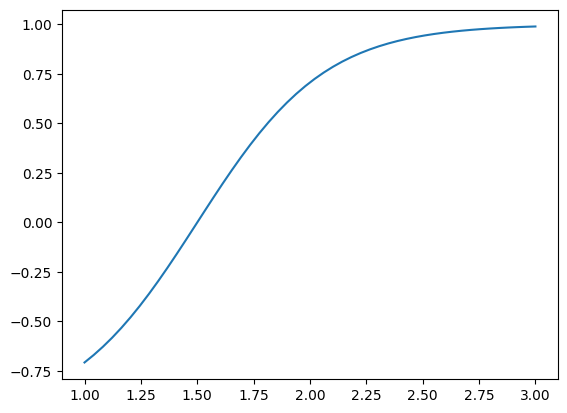

In [184]:
xs = np.linspace(1, 3, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
y = [math.tanh(1.764 * (x - 1.5)) for x in xs]

plt.plot(xs,y)
plt.show()

## Referências


https://math.stackexchange.com/questions/2282342/central-limit-theorem-poisson-equals-normal-tell-me-where-im-wrong

https://stats.stackexchange.com/questions/438060/does-this-code-demonstrate-the-central-limit-theorem/438117#438117


https://www.statology.org/normality-test-python/

https://stackoverflow.com/questions/73407488/how-to-check-the-normality-of-data-on-a-column-grouped-by-an-index


https://stats.stackexchange.com/questions/194182/beta-as-distribution-of-proportions-or-as-continuous-binomial

https://stats.stackexchange.com/questions/316086/distribution-that-has-a-range-from-0-to-1-and-with-peak-between-them


### Videos

https://www.youtube.com/watch?v=pYRG5X7110M

https://www.youtube.com/watch?v=RawXxYCOaig